In [137]:
from google_play_scraper import Sort, reviews_all
import pandas as pd
import numpy as np

result  = reviews_all(
    'com.icandesignapp.all',
    sleep_milliseconds=0, # defaults to 0
    lang='ko', # defaults to 'en'
    country='kr', # defaults to 'us'
    sort=Sort.MOST_RELEVANT, # defaults to Sort.MOST_RELEVANT
    filter_score_with= 0 # defaults to None(means all score)
)

df = pd.DataFrame(np.array(result), columns=['review'])
df = df.join(pd.DataFrame(df.pop('review').tolist()))

df.head()


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,9e36b31b-4d5b-4ec4-9ca5-82a1c78cbbca,지성,https://play-lh.googleusercontent.com/a-/AFdZu...,"벽 세우는게 간단해서 손가락만 있으면 가능. 단, 프로모드(현질)가 아니라서 정확한...",5,90,1072,2022-03-29 21:34:24,None,None
1,1d2317d1-b86d-40fc-a637-86acba6a78b7,정시우,https://play-lh.googleusercontent.com/a/AItbvm...,안녕하세요~ 이 게임 예전부터 즐겨했는데 괜찮고 문제 없었어요. 가구 진짜 많고 검...,5,20,None,2022-02-19 09:57:57,None,None
2,55cf37f0-bd73-4d1f-8edd-e1d9a1488edb,소현SOHYUN,https://play-lh.googleusercontent.com/a-/AFdZu...,"이사 전 가구배치, 인테리어 구상해 보기에 너무 유용하게 잘 쓰고 있었어요. 유료 ...",3,37,1023,2021-04-20 14:39:59,None,None
3,2fd3db64-a96d-4957-93f6-a3d5e0907d72,빵빵덕 좋아해요!,https://play-lh.googleusercontent.com/a-/AFdZu...,일단 광고도 안나오고 물건도 다양하고 사용하기도 쉽고 그런데 처음에 들어가면 현질이...,5,49,1009,2021-01-02 12:34:25,None,None
4,03f9ed15-4e62-4169-b656-6756658f013c,핫쪼코,https://play-lh.googleusercontent.com/a-/AFdZu...,아 너무 좋아요. 근데 제가 버그하나 제보좀 할게요. 버그 제보하는 방법을 몰라서 ...,5,35,1001,2020-12-06 16:59:53,None,None


In [138]:
df = df[['content','score']]
drop_index = df[df['score'] == 3].index

df = df.drop(drop_index)

df['score'].value_counts

df['label'] = np.where(df['score'] >=4 , 1, 0)

df = df[['content','label']]
df

,content,label
0,"벽 세우는게 간단해서 손가락만 있으면 가능. 단, 프로모드(현질)가 아니라서 정확한...",1
1,안녕하세요~ 이 게임 예전부터 즐겨했는데 괜찮고 문제 없었어요. 가구 진짜 많고 검...,1
3,일단 광고도 안나오고 물건도 다양하고 사용하기도 쉽고 그런데 처음에 들어가면 현질이...,1
4,아 너무 좋아요. 근데 제가 버그하나 제보좀 할게요. 버그 제보하는 방법을 몰라서 ...,1
5,인테리어하는거 좋아하는 사람은 진짜 강추 !! 안 좋아하는 사람들도 취미로 하기 재...,1
...,...,...
473,동찬시이,1
474,👍🏻,1
475,좋아여....,1
476,❤❤❤,1


In [140]:
df.to_csv('train.txt', sep='\t')

In [146]:
def read_data(filename):
    with open(filename, 'r',encoding='utf-8') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        # txt 파일의 헤더(id document label)는 제외하기
        data = data[1:]
    return data

all_data = read_data('train.txt')

In [148]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(all_data, test_size= 0.1, random_state=2000)


In [151]:
print(len(train_data))
print(len(train_data[0]))
print(len(test_data))
print(len(test_data[0]))

398
3
45
3


In [153]:
from konlpy.tag import Okt

okt = Okt()



In [154]:
import json
import os
from pprint import pprint

def tokenize(doc):
    # norm은 정규화, stem은 근어로 표시하기를 나타냄
    return ['/'.join(t) for t in okt.pos(doc, norm=True, stem=True)]

if os.path.isfile('train_docs.json'):
    with open('train_docs.json') as f:
        train_docs = json.load(f)
    with open('test_docs.json') as f:
        test_docs = json.load(f)
else:
    train_docs = [(tokenize(row[1]), row[2]) for row in train_data]
    test_docs = [(tokenize(row[1]), row[2]) for row in test_data]
    # JSON 파일로 저장
    with open('train_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(train_docs, make_file, ensure_ascii=False, indent="\t")
    with open('test_docs.json', 'w', encoding="utf-8") as make_file:
        json.dump(test_docs, make_file, ensure_ascii=False, indent="\t")

# 예쁘게(?) 출력하기 위해서 pprint 라이브러리 사용
pprint(train_docs[0])

(['나름/Noun', '만족/Noun', '중/Suffix'], '1')


In [155]:
tokens = [t for d in train_docs for t in d[0]]
print(len(tokens))

5987


In [156]:
import nltk
text = nltk.Text(tokens, name='NMSC')

# 전체 토큰의 개수
print(len(text.tokens))

# 중복을 제외한 토큰의 개수
print(len(set(text.tokens)))            

# 출현 빈도가 높은 상위 토큰 10개
pprint(text.vocab().most_common(10))

5987
1442
[('하다/Verb', 222),
 ('좋다/Adjective', 177),
 ('./Punctuation', 170),
 ('이/Josa', 104),
 ('가/Josa', 91),
 ('있다/Adjective', 88),
 ('도/Josa', 74),
 ('을/Josa', 73),
 ('너무/Adverb', 65),
 ('에/Josa', 64)]


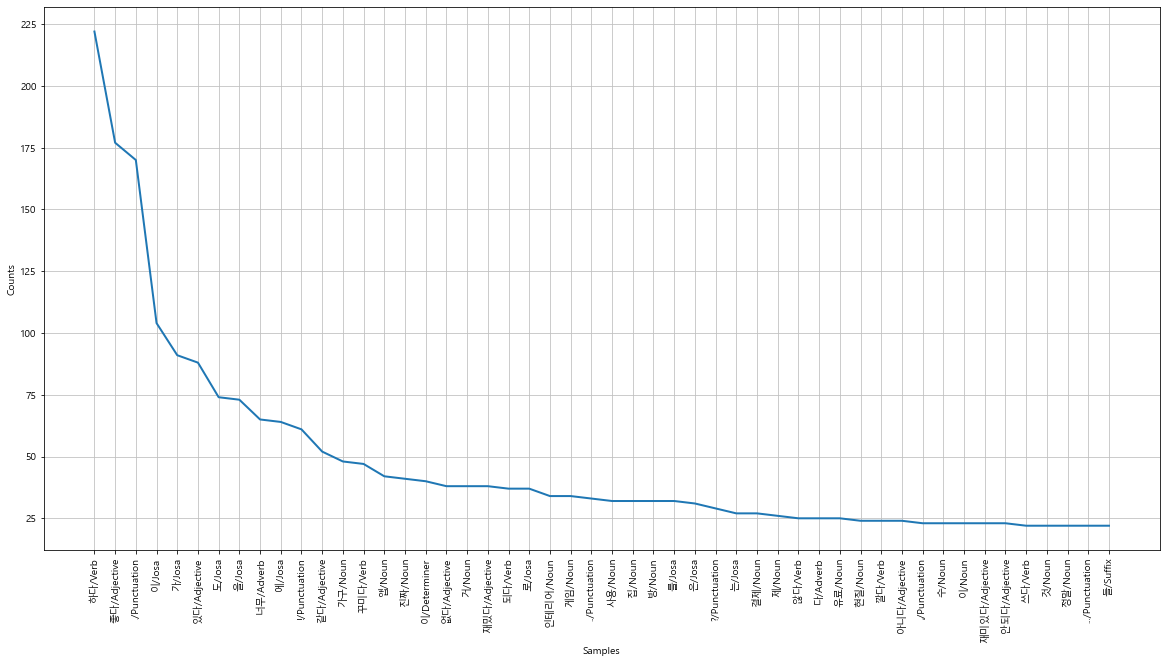

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [157]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

font_fname = 'malgun.ttf'
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

plt.figure(figsize=(20,10))
text.plot(50)

In [158]:
# 시간이 꽤 걸립니다! 시간을 절약하고 싶으면 most_common의 매개변수를 줄여보세요.
selected_words = [f[0] for f in text.vocab().most_common(100)]

def term_frequency(doc):
    return [doc.count(word) for word in selected_words]

train_x = [term_frequency(d) for d, _ in train_docs]
test_x = [term_frequency(d) for d, _ in test_docs]
train_y = [c for _, c in train_docs]
test_y = [c for _, c in test_docs]

In [159]:
import numpy as np

x_train = np.asarray(train_x).astype('float32')
x_test = np.asarray(test_x).astype('float32')

y_train = np.asarray(train_y).astype('float32')
y_test = np.asarray(test_y).astype('float32')

In [174]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(100,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model.fit(x_train, y_train, epochs=50, batch_size=512)
model.save('predict_pos_neg.h5')
results = model.evaluate(x_test, y_test)

Epoch 1/50
1/1 [==============================] - 0s 300ms/step - loss: 0.7311 - binary_accuracy: 0.4950
Epoch 2/50
1/1 [==============================] - 0s 6ms/step - loss: 0.6732 - binary_accuracy: 0.6633
Epoch 3/50
1/1 [==============================] - 0s 4ms/step - loss: 0.6428 - binary_accuracy: 0.7437
Epoch 4/50
1/1 [==============================] - 0s 10ms/step - loss: 0.6216 - binary_accuracy: 0.7638
Epoch 5/50
1/1 [==============================] - 0s 9ms/step - loss: 0.6046 - binary_accuracy: 0.7638
Epoch 6/50
1/1 [==============================] - 0s 8ms/step - loss: 0.5896 - binary_accuracy: 0.7739
Epoch 7/50
1/1 [==============================] - 0s 8ms/step - loss: 0.5759 - binary_accuracy: 0.7789
Epoch 8/50
1/1 [==============================] - 0s 3ms/step - loss: 0.5632 - binary_accuracy: 0.7764
Epoch 9/50
1/1 [==============================] - 0s 10ms/step - loss: 0.5509 - binary_accuracy: 0.7789
Epoch 10/50
1/1 [==============================] - 0s 7ms/step - loss

In [175]:
results

[0.46740955114364624, 0.800000011920929]

In [176]:
def predict_pos_neg(review):
    token = tokenize(review)
    tf = term_frequency(token)
    data = np.expand_dims(np.asarray(tf).astype('float32'), axis=0)
    score = float(model.predict(data))
    if(score > 0.5):
        print("[{}]는 {:.2f}% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^\n".format(review, score * 100))
    else:
        print("[{}]는 {:.2f}% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;\n".format(review, (1 - score) * 100))

In [177]:
predict_pos_neg("어플이 너무 좋은것 같습니다")

[어플이 너무 좋은것 같습니다]는 98.31% 확률로 긍정 리뷰이지 않을까 추측해봅니다.^^



In [178]:
predict_pos_neg('결제 유도가 너무 심합니다')

[결제 유도가 너무 심합니다]는 51.83% 확률로 부정 리뷰이지 않을까 추측해봅니다.^^;



In [110]:
def read_data(filename):
    with open(filename, 'r',encoding='utf-8') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        # txt 파일의 헤더(id document label)는 제외하기
        data = data[1:]
    return data

train_data = read_data('긍정리뷰.txt')
test_data = read_data('긍정리뷰_테스트.txt')

In [111]:
print(len(train_data))
print(len(train_data[0]))
print(len(test_data))
print(len(test_data[0]))

673
3
3
3


In [112]:
from konlpy.tag import Okt

okt = Okt()

In [113]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
             loss=losses.binary_crossentropy,
             metrics=[metrics.binary_accuracy])

model.fit(x_train, y_train, epochs=10, batch_size=512)
results = model.evaluate(x_test, y_test)

IndexError: list index out of range

In [87]:
import sys

f_n = open('negative_review.txt','w',encoding='utf-8')
f_n.write(neg_list)
f_n.close()

In [66]:
f_a = open('all_review.txt','w',encoding='utf-8')
f_a.write(all_list)
f_a.close()

In [67]:
f_p = open('postive_review.txt','w',encoding='utf-8')
f_p.write(tmp_list)
f_p.close()

Counter({'결제': 48, '앱': 36, '유료': 30, '가구': 29, '돈': 28, '사용': 23, '거': 22, '진짜': 22, '설치': 19, '환불': 19, '렉': 18, '것': 18, '벽': 18, '좀': 17, '별로': 16, '저장': 16, '구매': 15, '취소': 15, '현질': 14, '계속': 14, '집': 14, '무료': 14, '수': 14, '게임': 14, '버전': 13, '뭐': 12, '삭제': 12, '이': 12, '기능': 12, '자동': 12, '제': 11, '크기': 11, '임': 10, '인테리어': 10, '제발': 10, '터치': 10, '왜': 10, '처음': 9, '하나': 9, '갑자기': 9, '전': 9, '자꾸': 8, '조작': 8, '프로': 8, '때': 8, '추가': 8, '정말': 8, '방': 8, '어플': 8, '조절': 8, '저': 8, '다시': 7, '광고': 7, '리뷰': 7, '최악': 7, '그냥': 7, '더': 7, '정도': 7, '요': 7, '돈내': 7, '보고': 6, '점': 6, '유도': 6, '개': 6, '해': 6, '내야': 6, '추천': 6, '암': 5, '내': 5, '마음': 5, '함': 5, '다운': 5, '다운로드': 5, '또': 5, '데': 5, '업데이트': 5, '사진': 5, '매우': 4, '버그': 4, '도면': 4, '회전': 4, '방향': 4, '모든': 4, '다른': 4, '크게': 4, '곳': 4, '디자인': 4, '랙': 4, '요청': 4, '번역': 4, '한번': 4, '게': 4, '직접': 4, '못': 4, '자체': 4, '바로': 4, '치수': 4, '동안': 4, '차라리': 4, '로그인': 4, '결재': 4, '템': 4, '건': 4, '조명': 4, '튜토리얼': 4, '재미': 4, '영어': 4, '창': 3, '자주':

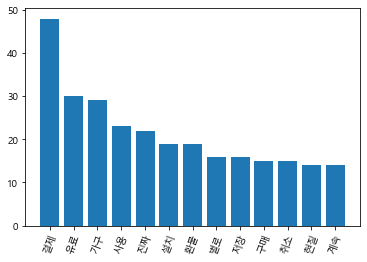

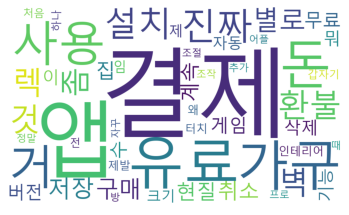

In [69]:
#-*- coding: utf-8 -*-
import os
import sys
import urllib.request
import json
import re
from collections import Counter
from matplotlib import font_manager, rc
from wordcloud import WordCloud
from konlpy.tag import Okt
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk import Text

okt = Okt()

with open('negative_review.txt', 'r', encoding='utf-8') as file:
    x = file.read()

tmp_list = okt.pos(x, norm=True, stem=True)
myList_filter = [x for x, y in tmp_list if y in ['Noun']]
count = Counter(myList_filter)
print(count)

words = (dict(count.most_common()))
Okt = Text(myList_filter, name="Okt")
wordInfo = dict()
for tags, counts in Okt.vocab().most_common(20):
    if (len(str(tags)) > 1):
        wordInfo[tags] = counts
values = sorted(wordInfo.values(), reverse=True)
keys = sorted(wordInfo, key=wordInfo.get, reverse=True)

#오류 방지 폰트 설정
font_location = "malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)

# plt 그래프
plt.bar(range(len(wordInfo)), values, align='center')
plt.xticks(range(len(wordInfo)), list(keys), rotation='70')
plt.show()

# wordcloud
wc = WordCloud(width = 1000, height = 600, background_color="white", font_path=font_location, max_words=50)
plt.imshow(wc.generate_from_frequencies(Okt.vocab()))
plt.axis("off")
plt.show()

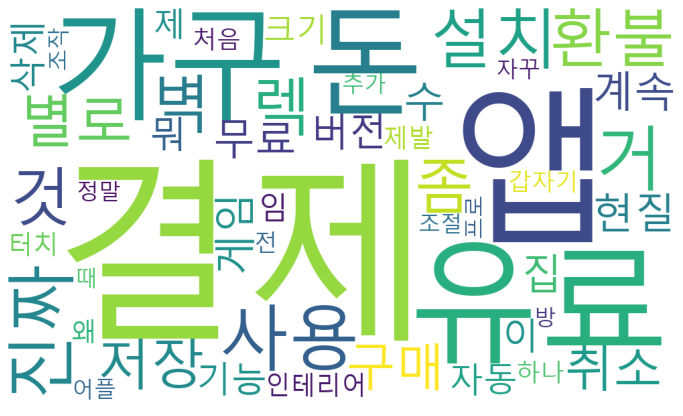

In [70]:
plt.figure(figsize=(12,12))
wc = WordCloud(width = 1000, height = 600, background_color="white", font_path=font_location, max_words=50)

plt.imshow(wc.generate_from_frequencies(Okt.vocab()))

plt.axis("off")
plt.show()

Counter({'인테리어': 5427, '공간': 2135, '시뮬레이션': 2041, '집': 1749, '디자인': 1559, '가구': 1481, '도면': 1316, '선택': 1099, '배치': 1064, '작업': 858, '시공': 809, '확인': 801, '진행': 763, '아파트': 723, '거실': 688, '상담': 684, '스타일': 664, '모델링': 652, '견적': 648, '사용': 605, '주방': 599, '공사': 583, '생각': 581, '고객': 574, '업체': 547, '사진': 539, '느낌': 537, '방': 515, '제작': 512, '조명': 508, '부분': 502, '서비스': 478, '바로': 467, '벽': 438, '정말': 438, '설계': 421, '실제': 419, '의뢰': 408, '구조': 408, '직접': 401, '제품': 391, '이미지': 388, '시간': 388, '자재': 386, '경우': 383, '설치': 381, '시작': 380, '나': 378, '로': 377, '미리': 369, '모습': 364, '현장': 363, '고민': 344, '이용': 342, '블렌드': 341, '샘': 341, '전체': 336, '저희': 335, '게임': 332, '요': 325, '를': 325, '컬러': 323, '바닥': 321, '분위기': 321, '가지': 320, '보고': 314, '실': 313, '활용': 312, '클릭': 304, '거': 304, '화이트': 302, '프로그램': 301, '취향': 301, '완성': 299, '마음': 299, '정도': 296, '타일': 296, '가장': 291, '수납': 290, '추천': 288, '요즘': 283, '중': 281, '안방': 274, '구매': 274, '베이스': 272, '층': 270, '위치': 269, '어': 268, '이번': 262,

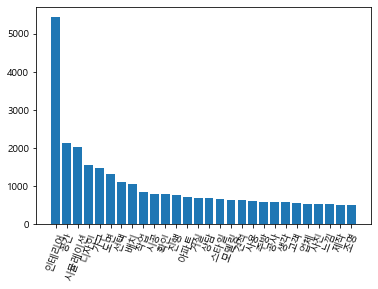

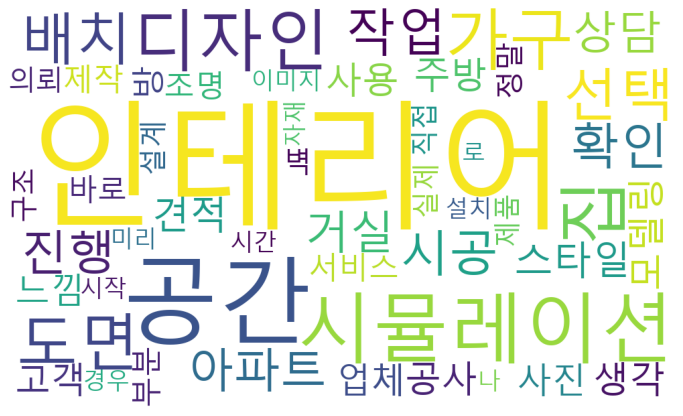

In [181]:
#-*- coding: utf-8 -*-
import os
import sys
import urllib.request
import json
import re
from collections import Counter
from matplotlib import font_manager, rc
from wordcloud import WordCloud
from konlpy.tag import Okt
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk import Text

okt = Okt()
stop_word =['수','곳','후','이','등','것','리','위','으','분','때','내','볼','저','하나','우리',
            '더','그','전', '점', '제', '위해', '때문', '오늘', '및', '통해']

with open('인테리어 시뮬레이션.txt', 'r', encoding='utf-8') as file:
    x = file.read()

tmp_list = okt.pos(x, norm=True, stem=True)
myList_filter = [x for x, y in tmp_list if (y in ['Noun']) & (x not in stop_word)]
count = Counter(myList_filter)
print(count)

words = (dict(count.most_common()))
Okt = Text(myList_filter, name="Okt")
wordInfo = dict()
for tags, counts in Okt.vocab().most_common(30):
    if (len(str(tags)) > 1):
        wordInfo[tags] = counts
values = sorted(wordInfo.values(), reverse=True)
keys = sorted(wordInfo, key=wordInfo.get, reverse=True)

#오류 방지 폰트 설정
font_location = "malgun.ttf"
font_name = font_manager.FontProperties(fname=font_location).get_name()
rc('font', family=font_name)

# plt 그래프
plt.bar(range(len(wordInfo)), values, align='center')
plt.xticks(range(len(wordInfo)), list(keys), rotation='70')
plt.show()

# wordcloud
wc = WordCloud(width = 1000, height = 600, background_color="white", font_path=font_location, max_words=50)
plt.figure(figsize=(12,12))
plt.imshow(wc.generate_from_frequencies(Okt.vocab()))
plt.axis("off")
plt.show()

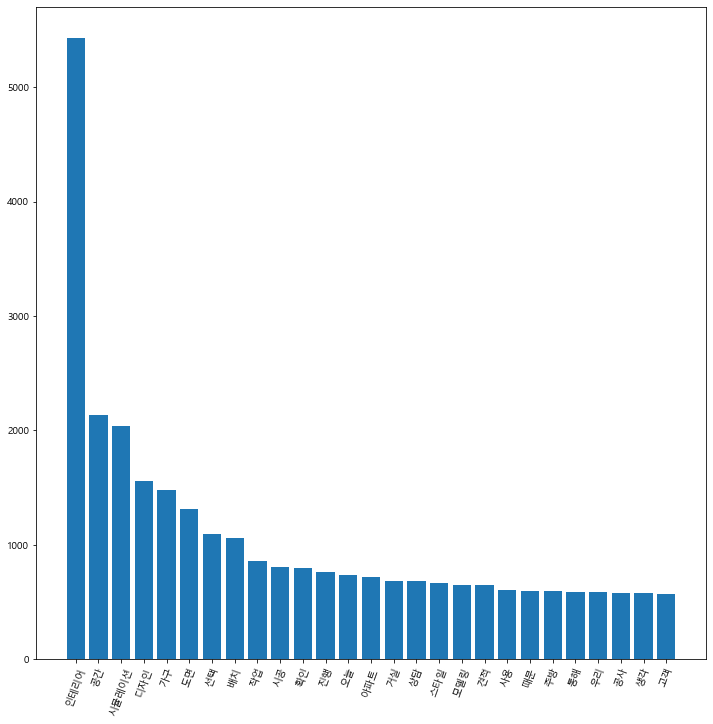

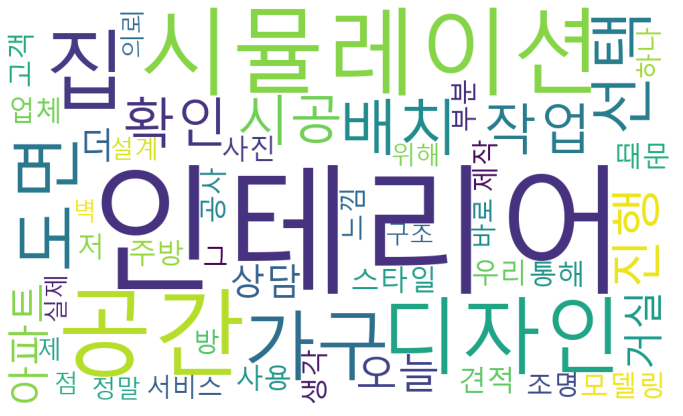

In [82]:
# plt 그래프
plt.figure(figsize=(12,12))
plt.bar(range(len(wordInfo)), values, align='center')
plt.xticks(range(len(wordInfo)), list(keys), rotation='70')
plt.show()

# wordcloud
wc = WordCloud(width = 1000, height = 600, background_color="white", font_path=font_location, max_words=50)
plt.figure(figsize=(12,12))
plt.imshow(wc.generate_from_frequencies(Okt.vocab()))
plt.axis("off")
plt.show()